# Colony Counter : Exploratory Data Analysis

This notebook explore the Data of our colony counter dataset.

**Goals:**
- Understand dataset structure and label distribution  
- Check for missing or corrupted samples  
- Inspect image quality (brightness/contrast)  
- Visualize representative wells


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

# ML utility
from sklearn.model_selection import train_test_split

### Dataset importation

In [2]:

CSV_PATH = "data/dataset.csv" 

df = pd.read_csv(CSV_PATH)

print("\nColumns:")
print(df.columns.to_list())

print(f"Loaded {len(df)} samples ✔️")

print("\nSample rows:")
df.head()


Columns:
['filename', 'value', 'is_countable', 'path', 'plate_type', 'plate_id', 'well']
Loaded 792 samples ✔️

Sample rows:


,filename,value,is_countable,path,plate_type,plate_id,well
0,Brisbane_plate3_C1.jpg,-1,0,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,C1
1,Brisbane_plate3_A3.jpg,2,1,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,A3
2,Brisbane_plate3_A1.jpg,-1,0,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,A1
3,Brisbane_plate3_B1.jpg,-1,0,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,B1
4,Brisbane_plate3_B4.jpg,1,1,data/cropped_wells/Brisbane/plate_3/Brisbane_p...,Brisbane,plate3,B4


## Dataset Overview & Label Distributions (Handling `-1` Unreadable Cases)

In this section, we analyze the dataset structure and label distribution, taking into account that:
- `value = -1` represents wells that are **too full to count** and should be considered as a separate class.
  
We will:
- inspect dataset consistency,
- visualize distributions where `-1` is shown separately on the right,
- and analyze how uncountable wells relate to plate types and plates.

This helps detect label imbalance, dataset health, and potential biases between readable and unreadable wells.


### Basic Stats (excluding -1)

In [3]:
readable_df = df[df['value'] != -1]

print("Statistics for COUNTABLE wells:")
readable_df['value'].describe()

Statistics for COUNTABLE wells:


count    618.000000
mean       6.464401
std       15.016669
min        0.000000
25%        0.000000
50%        0.000000
75%        4.000000
max      110.000000
Name: value, dtype: float64

In [4]:
print("Missing values per column:")
df.isna().sum()


Missing values per column:


filename        0
value           0
is_countable    0
path            0
plate_type      0
plate_id        0
well            0
dtype: int64

In [5]:
nan_rows = df[df.isna().any(axis=1)]
nan_rows

,filename,value,is_countable,path,plate_type,plate_id,well


### Unique Values & Value Categories

In [6]:
unique_values = df['value'].unique()
print("Unique 'value' entries:", np.sort(unique_values))
print("\nNumber of unique entries:", len(unique_values))

print("\nCount of UNREADABLE samples (value = -1):", (df['value'] == -1).sum())
print("Count of READABLE samples:", (df['value'] != -1).sum())


Unique 'value' entries: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  39  40  41  42  45  46  47  49  51  53  54  55  56  57  58  60
  61  65  75  92  94 102 107 110]

Number of unique entries: 62

Count of UNREADABLE samples (value = -1): 174
Count of READABLE samples: 618


### Label distribution

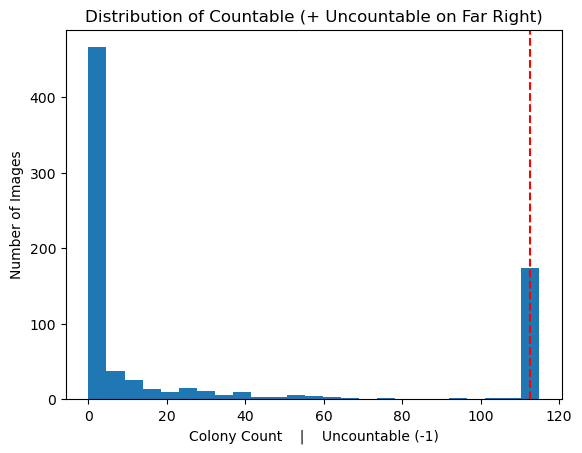


Distribution including -1:
value
-1      174
 0      379
 1       38
 2       24
 3       14
       ... 
 92       1
 94       1
 102      1
 107      1
 110      1
Name: count, Length: 62, dtype: int64


In [7]:
# Build a sequence where -1 sits far to the right
vals = df['value'].copy()

# Map -1 to a large synthetic position for visualization
PLOT_MAX = vals[vals != -1].max() + 5
vals_for_plot = vals.replace(-1, PLOT_MAX)

plt.hist(vals_for_plot, bins=25)
plt.title("Distribution of Countable (+ Uncountable on Far Right)")
plt.xlabel("Colony Count    |    Uncountable (-1)")
plt.ylabel("Number of Images")

# vertical line to highlight where uncountable sits
plt.axvline(PLOT_MAX - 2.5, color='red', linestyle='--')
plt.show()

print("\nDistribution including -1:")
print(df['value'].value_counts().sort_index())

### Plate type distribution 

In [8]:
plate_stats = df.groupby('plate_type')['value'].agg(
    total="count",
    uncountable=lambda x: (x == -1).sum(),
    readable=lambda x: (x != -1).sum(),
    mean_count=lambda x: x[x != -1].mean()
)

plate_stats['uncountable_ratio'] = plate_stats['uncountable'] / plate_stats['total']

plate_stats.sort_values(by='uncountable_ratio', ascending=False)



,total,uncountable,readable,mean_count,uncountable_ratio
plate_type,,,,,
PR8v,168,99,69,12.231884,0.589286
IBV,84,33,51,14.901961,0.392857
Brisbane,120,27,93,13.612903,0.225000
Panama,144,6,138,2.724638,0.041667
PR8,276,9,267,2.805243,0.032609


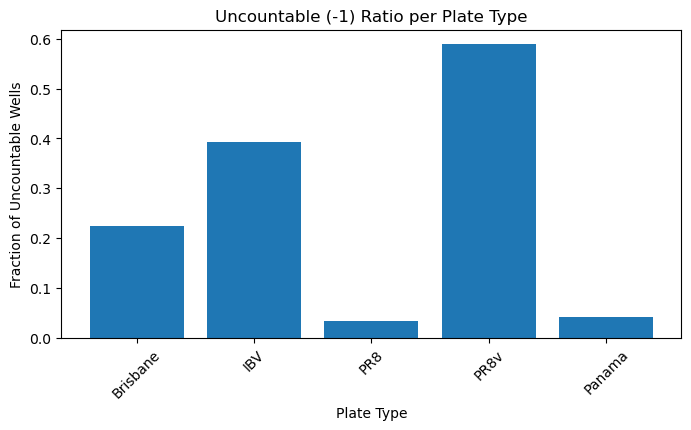

In [9]:
plt.figure(figsize=(8,4))
plt.bar(plate_stats.index, plate_stats['uncountable_ratio'])
plt.title("Uncountable (-1) Ratio per Plate Type")
plt.ylabel("Fraction of Uncountable Wells")
plt.xlabel("Plate Type")
plt.xticks(rotation=45)
plt.show()



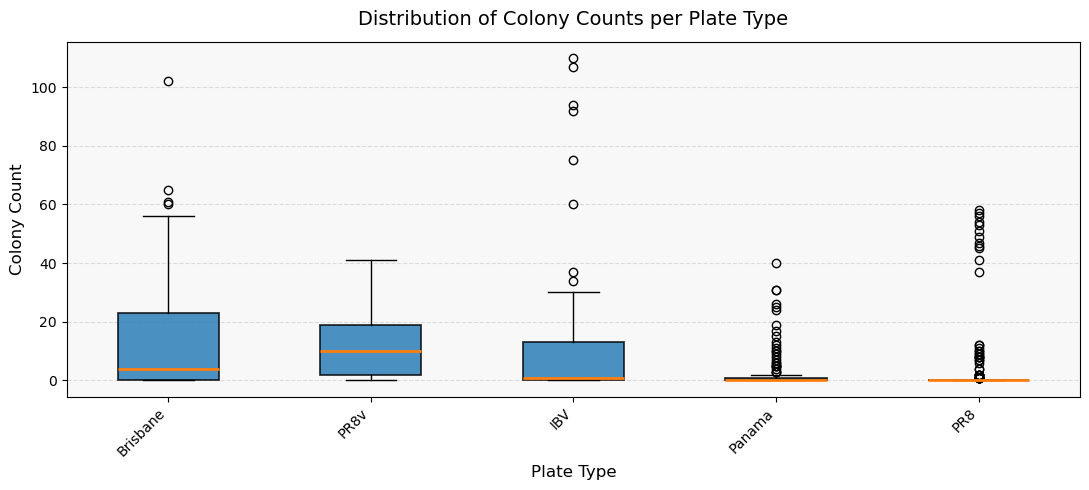

In [10]:
# Filter only readable wells
readable_df = df[df['value'] >= 0]

# Extract plate types
types = readable_df['plate_type'].unique()

# Prepare values grouped by plate type
data_groups = [readable_df[readable_df['plate_type'] == t]['value'] for t in types]

plt.figure(figsize=(11,5))

# Create boxplot with modern Matplotlib style
box = plt.boxplot(
    data_groups,
    patch_artist=True,   # allows box face coloring
    medianprops={'linewidth': 2},
)

# Light gray grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add subtle background shadow behind boxes
for b in box['boxes']:
    b.set_alpha(0.8)  # slight transparency
    b.set_linewidth(1.3)
    b.set_edgecolor("black")

# Add a soft drop shadow rectangle behind the plot
plt.gca().set_facecolor('#f8f8f8')  # creamy background

plt.title("Distribution of Colony Counts per Plate Type", fontsize=14, pad=12)
plt.ylabel("Colony Count", fontsize=12)
plt.xlabel("Plate Type", fontsize=12)

# Display plate types on x-axis
plt.xticks(np.arange(1, len(types)+1), types, rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Interpretation

In general we can see a high imbalance with way more 0 labels than other numbers which could lead to overfitting

## Image Quality Analysis: Brightness, Contrast & Outliers

To better understand the dataset beyond labels, we now examine core image properties:
- overall brightness,
- pixel contrast,
- variability across plate types,
- and extreme cases that might correspond to unreadable wells.

This helps answer questions like:
- Are uncountable wells overexposed or underexposed?
- Are some plate types systematically darker?
- Do anomaly images exist that should be removed or corrected?

We compute brightness and contrast for each image and visualize their distributions, as well as potential correlations with labels.


# Results

### Evaluation of the classifier (Countable VS Uncountable)

Here is an histogram showing correctly classified wells between countabe and uncountable in the test set.

We see that 100% of our wells are correctly classified


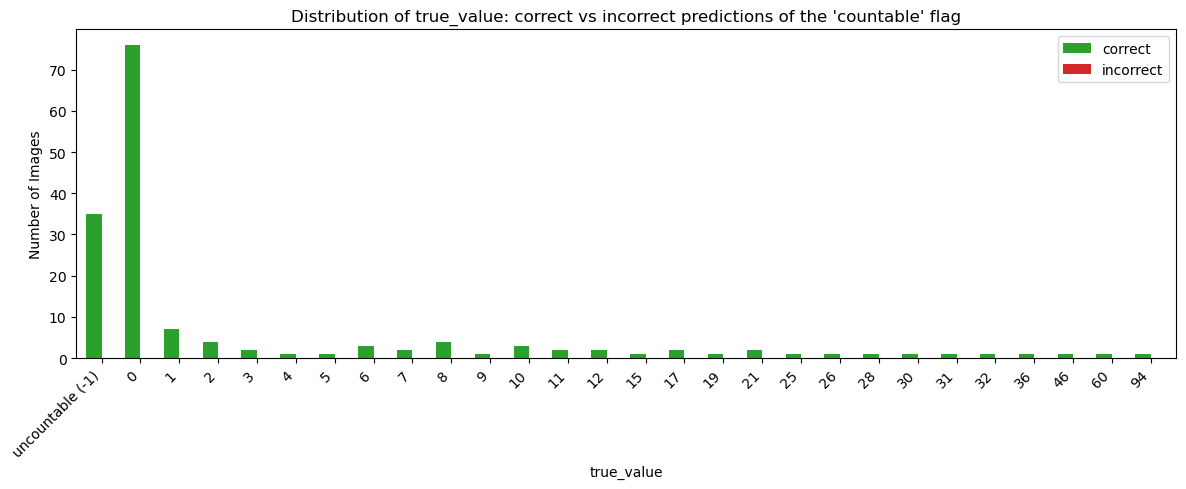

Total samples: 159 | Correctly classified : 159 | Incorrect: 0


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

PRED_CSV = "pipeline_results.csv" 
preds = pd.read_csv(PRED_CSV)


preds['correct_flag'] = preds['pred_is_countable'] == preds['true_is_countable']

cnt_correct = preds[preds['correct_flag']]['true_value'].value_counts().sort_index()
cnt_incorrect = preds[~preds['correct_flag']]['true_value'].value_counts().sort_index()

all_vals = sorted(set(cnt_correct.index.tolist() + cnt_incorrect.index.tolist()))
cnt_df = pd.DataFrame({
    'correct': [cnt_correct.get(v, 0) for v in all_vals],
    'incorrect': [cnt_incorrect.get(v, 0) for v in all_vals]
}, index=all_vals)

labels = [("uncountable (-1)" if v == -1 else str(int(v))) for v in cnt_df.index]

ax = cnt_df.plot(kind='bar', figsize=(12,5), color=['tab:green','tab:red'], width=0.8)
ax.set_title("Distribution of true_value: correct vs incorrect predictions of the 'countable' flag")
ax.set_xlabel("true_value")
ax.set_ylabel("Number of Images")
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Quick summary
total = len(preds)
n_correct = preds['correct_flag'].sum()
n_incorrect = total - n_correct
print(f"Total samples: {total} | Correctly classified : {n_correct} | Incorrect: {n_incorrect}")

### Evaluation of the counter

# Evaluation of the counter (±10%)

Within the countable wells we assess prediction quality using a ±10% tolerance.  

The first two plots are histograms of true_value for predictions within ±10% (correct) versus outside ±10% (incorrect).  

Below is a scatter plot of predicted_count vs true_value with the identity line and ±10% bands to highlight errors.  

Analysis of those plots show that most correct predictions are concentrated at true_value = 0. otherwise the counter is not performing well

Comparable samples (true_value != -1): 124
Within ±10%: 78 (62.9%)  |  Outside: 46


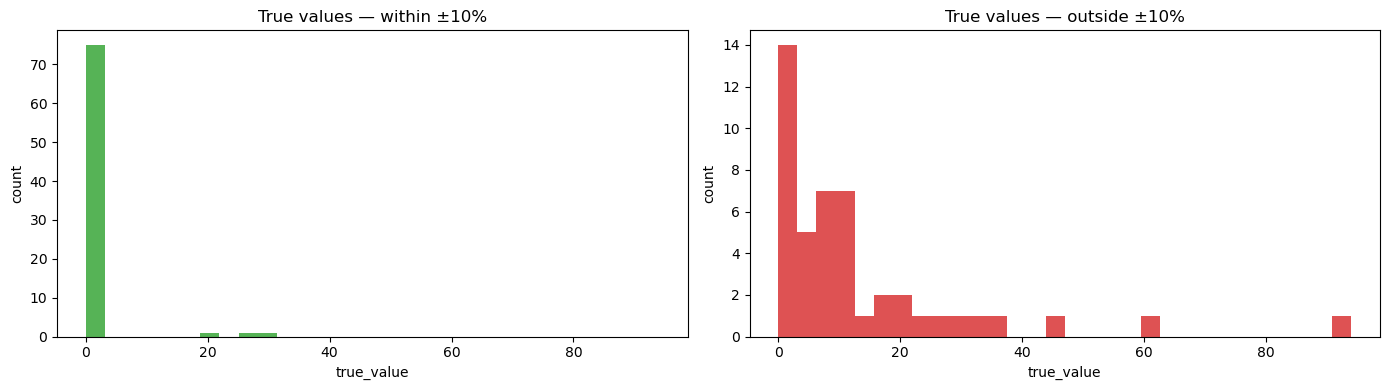

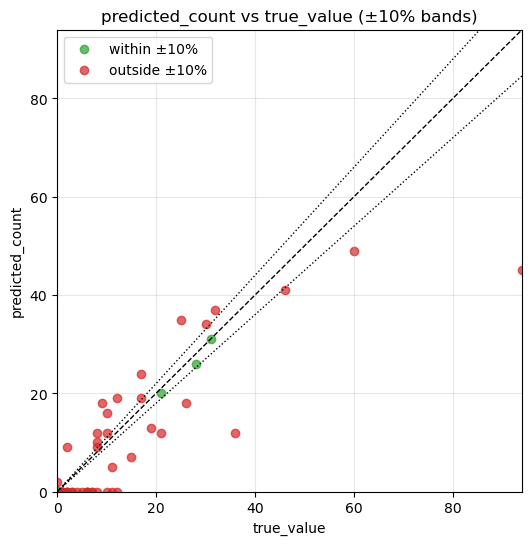

In [12]:

# Nouvelle cellule : comparaison predicted_count vs true_value (marge 10%)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PRED_CSV = "pipeline_results.csv"
preds = pd.read_csv(PRED_CSV)

# Coerce en numérique (les cases vides deviennent NaN)
preds['predicted_count'] = pd.to_numeric(preds['predicted_count'], errors='coerce')
preds['true_value'] = pd.to_numeric(preds['true_value'], errors='coerce')

# Exclure les cas non comparables (true_value == -1 = uncountable)
comp = preds[preds['true_value'] != -1].copy()

# Définir la condition "within 10%"
def within_10pct(row):
    tv = row['true_value']
    pc = row['predicted_count']
    if np.isnan(pc) or np.isnan(tv):
        return False
    if tv == 0:
        # tolérance absolue pour zéro (autorise petites prédictions proches de 0)
        return abs(pc) <= 0.5
    return abs(pc - tv) <= 0.10 * tv

comp['within_10pct'] = comp.apply(within_10pct, axis=1)

# Résumé
n_total = len(comp)
n_within = comp['within_10pct'].sum()
n_out = n_total - n_within
pct_within = 100 * n_within / n_total if n_total else 0

print(f"Comparable samples (true_value != -1): {n_total}")
print(f"Within ±10%: {n_within} ({pct_within:.1f}%)  |  Outside: {n_out}")

# Histogrammes côte à côte : true_value pour bons vs mauvais
bins = np.histogram_bin_edges(comp['true_value'].dropna(), bins=30)

fig, axes = plt.subplots(1,2, figsize=(14,4))
axes[0].hist(comp[comp['within_10pct']]['true_value'], bins=bins, color='tab:green', alpha=0.8)
axes[0].set_title('True values — within ±10%')
axes[0].set_xlabel('true_value')
axes[0].set_ylabel('count')

axes[1].hist(comp[~comp['within_10pct']]['true_value'], bins=bins, color='tab:red', alpha=0.8)
axes[1].set_title('True values — outside ±10%')
axes[1].set_xlabel('true_value')
axes[1].set_ylabel('count')

plt.tight_layout()
plt.show()

# Scatter predicted vs true avec lignes ±10%
tv = comp['true_value']
pc = comp['predicted_count']
mask_valid = ~pc.isna()

plt.figure(figsize=(6,6))
plt.scatter(tv[mask_valid & comp['within_10pct']], pc[mask_valid & comp['within_10pct']], 
            color='tab:green', label='within ±10%', alpha=0.7)
plt.scatter(tv[mask_valid & ~comp['within_10pct']], pc[mask_valid & ~comp['within_10pct']], 
            color='tab:red', label='outside ±10%', alpha=0.7)

# identite et bandes
lims = [0, max(tv.max(), pc.max(skipna=True) if not pc.dropna().empty else 1)]
plt.plot(lims, lims, 'k--', linewidth=1)  # y = x
plt.plot(lims, [l*1.10 for l in lims], 'k:', linewidth=1)  # +10%
plt.plot(lims, [l*0.90 for l in lims], 'k:', linewidth=1)  # -10%

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('true_value')
plt.ylabel('predicted_count')
plt.title('predicted_count vs true_value (±10% bands)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Data Augmentation

We did a stratified data augmentation. Here is the histogram of the new data

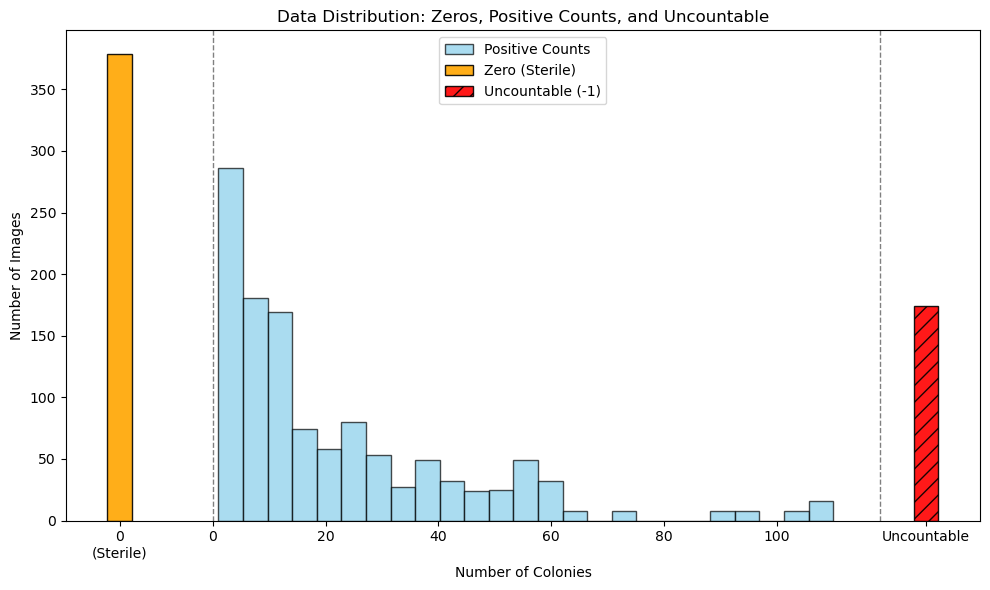

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. DATA LOADING ---
# Check if values already exist to avoid reloading if the script is run multiple times
try:
    values
    has_values = True
except NameError:
    has_values = False

if not has_values:
    AUG_DIR = os.path.join("data", "augmented_wells")
    CSV_PATH = os.path.join("data", "dataset.csv")
    INPUT_DIR = os.path.join("data", "cropped_wells")

    df_csv = pd.read_csv(CSV_PATH)

    def rel_to_dir_and_stem(rel_path):
        d = os.path.dirname(rel_path)
        stem = os.path.splitext(os.path.basename(rel_path))[0]
        return d, stem

    label_map = {}
    for _, row in df_csv.iterrows():
        raw_path = str(row.get("path", ""))
        try:
            value = float(row.get("value"))
        except Exception:
            continue
        rel = raw_path
        try:
            # Basic handling of relative/absolute paths
            rel = os.path.relpath(raw_path, INPUT_DIR) if not os.path.isabs(raw_path) else os.path.relpath(raw_path, INPUT_DIR)
        except Exception:
            pass
        rel_dir, rel_stem = rel_to_dir_and_stem(rel)
        label_map[(rel_dir, rel_stem)] = value

    def parse_augmented_name(filename):
        name = os.path.splitext(os.path.basename(filename))[0]
        if name.endswith("_orig"):
            return name[:-5]
        if "_aug_" in name:
            return name.split("_aug_")[0]
        return name

    values = []
    for root, _, files in os.walk(AUG_DIR):
        rel_dir = os.path.relpath(root, AUG_DIR)
        for f in files:
            if not f.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            stem = parse_augmented_name(f)
            v = label_map.get((rel_dir, stem))
            if v is not None:
                values.append(v)

# --- 2. CREATE SPECIAL PLOT ---

if not values:
    print("No images found in augmented_wells.")
else:
    vals = pd.Series(values, dtype=float).copy()

    # 1. Separate the three categories
    zeros = vals[vals == 0]
    uncountables = vals[vals == -1]
    positives = vals[vals > 0]

    # 2. Define limits for graphical placement
    if positives.empty:
        max_val = 10  # Default value if no positive data exists
    else:
        max_val = positives.max()
    
    # Define a visual "gap" of about 15% of the graph width
    gap = max_val * 0.15
    
    # Artificial positions on the X-axis
    pos_zero_bar = -gap                  # To the left of 0
    pos_uncountable_bar = max_val + gap  # To the right of max

    plt.figure(figsize=(10, 6))

    # A. Plot the main histogram for real values (>0)
    # Get bin info to calculate ideal width for special bars
    counts, bins, patches = plt.hist(positives, bins=25, color='skyblue', edgecolor='black', alpha=0.7, label='Positive Counts')
    
    # Calculate aesthetic bar width (average width of bins)
    if len(bins) > 1:
        avg_width = (bins[-1] - bins[0]) / (len(bins) - 1)
    else:
        avg_width = gap / 2

    # B. Plot the special "0" bar (Left)
    plt.bar(pos_zero_bar, len(zeros), width=avg_width, color='orange', edgecolor='black', alpha=0.9, label='Zero (Sterile)')

    # C. Plot the special "-1" bar (Right)
    plt.bar(pos_uncountable_bar, len(uncountables), width=avg_width, color='red', edgecolor='black', alpha=0.9, hatch='//', label='Uncountable (-1)')

    # --- 3. AESTHETICS AND LEGENDS ---
    
    plt.title("Data Distribution: Zeros, Positive Counts, and Uncountable")
    plt.ylabel("Number of Images")
    plt.xlabel("Number of Colonies")

    # Vertical separator lines to distinguish zones
    plt.axvline(0, color='gray', linestyle='--', linewidth=1) # Separates 0 from positives
    plt.axvline(max_val + (gap/2), color='gray', linestyle='--', linewidth=1) # Separates positives from uncountables

    # Modify X-axis labels (Ticks)
    # Keep normal ticks for positives, add our two special ones
    current_ticks = list(plt.xticks()[0])
    
    # Filter automatic ticks to keep only those that are positive (to avoid cluttering the "Zero" zone)
    clean_ticks = [t for t in current_ticks if 0 <= t <= max_val]
    
    final_ticks = [pos_zero_bar] + clean_ticks + [pos_uncountable_bar]
    final_labels = ["0\n(Sterile)"] + [str(int(t)) for t in clean_ticks] + ["Uncountable"]

    plt.xticks(final_ticks, final_labels)

    plt.legend()
    plt.tight_layout()
    plt.show()

## Augmented predictions analysis

### Predictions overview

Comparable samples (true_value != -1): 315
Within ±(10% + 1): 212 (67.3%)  |  Outside: 103


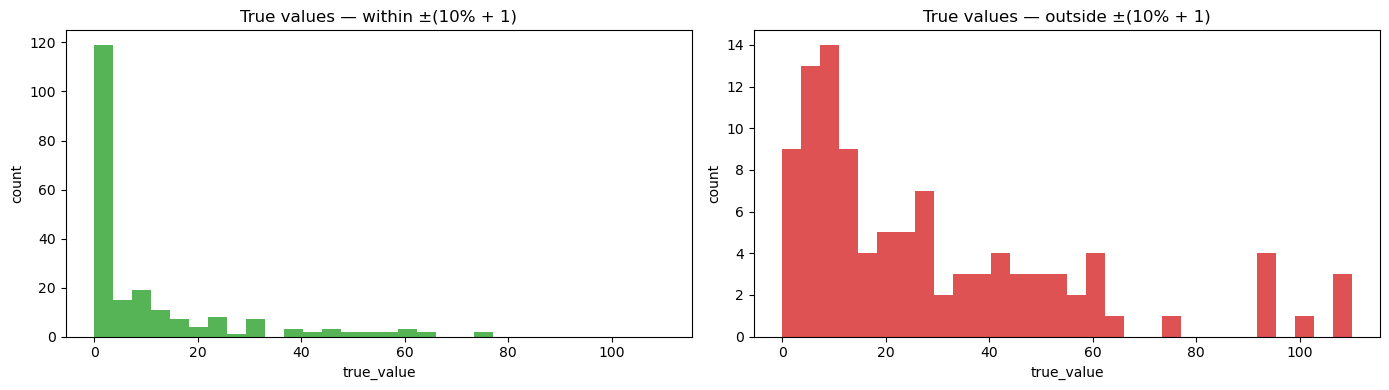

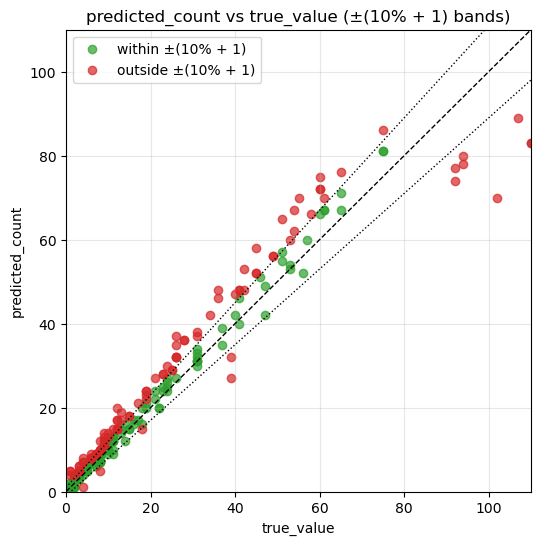

In [ ]:

# Nouvelle cellule : comparaison predicted_count vs true_value (marge 10% + 1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PRED_CSV = "z.csv"
# Si le fichier n'existe pas, commentez la ligne ci-dessous ou adaptez le chemin
try:
    preds = pd.read_csv(PRED_CSV)
except FileNotFoundError:
    print(f"Fichier {PRED_CSV} introuvable. Assurez-vous qu'il est dans le répertoire.")
    # Pour l'exemple, on peut créer un DataFrame vide ou simuler des données si nécessaire
    preds = pd.DataFrame(columns=['predicted_count', 'true_value'])

# Coerce en numérique (les cases vides deviennent NaN)
preds['predicted_count'] = pd.to_numeric(preds['predicted_count'], errors='coerce')
preds['true_value'] = pd.to_numeric(preds['true_value'], errors='coerce')

# Exclure les cas non comparables (true_value == -1 = uncountable)
comp = preds[preds['true_value'] != -1].copy()

# Définir la condition "within 10% + 1"
def within_tolerance(row):
    tv = row['true_value']
    pc = row['predicted_count']
    if np.isnan(pc) or np.isnan(tv):
        return False
    
    # Nouvelle marge : 10% de la valeur réelle + 1 unité
    # Condition : |predicted - true| <= (0.10 * true + 1)
    tolerance = 0.10 * tv + 1
    return abs(pc - tv) <= tolerance

comp['within_tol'] = comp.apply(within_tolerance, axis=1)

# Résumé
n_total = len(comp)
n_within = comp['within_tol'].sum()
n_out = n_total - n_within
pct_within = 100 * n_within / n_total if n_total else 0

print(f"Comparable samples (true_value != -1): {n_total}")
print(f"Within ±(10% + 1): {n_within} ({pct_within:.1f}%)  |  Outside: {n_out}")

# Histogrammes côte à côte : true_value pour bons vs mauvais
bins = np.histogram_bin_edges(comp['true_value'].dropna(), bins=30)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(comp[comp['within_tol']]['true_value'], bins=bins, color='tab:green', alpha=0.8)
axes[0].set_title('True values — within ±(10% + 1)')
axes[0].set_xlabel('true_value')
axes[0].set_ylabel('count')

axes[1].hist(comp[~comp['within_tol']]['true_value'], bins=bins, color='tab:red', alpha=0.8)
axes[1].set_title('True values — outside ±(10% + 1)')
axes[1].set_xlabel('true_value')
axes[1].set_ylabel('count')

plt.tight_layout()
plt.show()

# Scatter predicted vs true avec lignes ±(10% + 1)
tv = comp['true_value']
pc = comp['predicted_count']
mask_valid = ~pc.isna()

plt.figure(figsize=(6, 6))
plt.scatter(tv[mask_valid & comp['within_tol']], pc[mask_valid & comp['within_tol']], 
            color='tab:green', label='within ±(10% + 1)', alpha=0.7)
plt.scatter(tv[mask_valid & ~comp['within_tol']], pc[mask_valid & ~comp['within_tol']], 
            color='tab:red', label='outside ±(10% + 1)', alpha=0.7)

# Identité et bandes
lims_max = max(tv.max(), pc.max(skipna=True) if not pc.dropna().empty else 1)
x_vals = np.linspace(0, lims_max, 100)

plt.plot([0, lims_max], [0, lims_max], 'k--', linewidth=1)  # y = x

# Bandes de tolérance : y = x ± (0.1x + 1)
# Upper limit: y = 1.1x + 1
plt.plot(x_vals, 1.10 * x_vals + 1, 'k:', linewidth=1) 
# Lower limit: y = 0.9x - 1
plt.plot(x_vals, 0.90 * x_vals - 1, 'k:', linewidth=1)

plt.xlim([0, lims_max])
plt.ylim([0, lims_max])
plt.xlabel('true_value')
plt.ylabel('predicted_count')
plt.title('predicted_count vs true_value (±(10% + 1) bands)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Comparing types of plates predictions 

In [ ]:
# ------------------------------------
# Extract plate_type and plate_id
# ------------------------------------
preds["plate_type"] = preds["path"].apply(
    lambda p: p.split("augmented_wells/")[1].split("/")[0]
)

preds["plate_id"] = preds["path"].apply(
    lambda p: p.split("/")[2]  # 'plate_3'
)

# ------------------------------------
# Per-plate evaluation
# ------------------------------------
plate_stats = []

for ptype in sorted(preds["plate_type"].unique()):
    sub = preds[preds["plate_type"] == ptype].copy()

    # Only wells that are TRUE countable AND classified countable
    valid_mask = (
        (sub["true_is_countable"] == 1) &
        (sub["pred_is_countable"] == 1)
    )
    valid = sub[valid_mask]

    if len(valid) == 0:
        plate_stats.append({
            "plate_type": ptype,
            "n_samples": 0,
            "MAE": None,
            "R2": None,
            "mean_bias": None,
            "% within 10%": None,
            "median_abs_error": None,
            "Q1_error": None,
            "Q3_error": None,
            "Consistency Score": None,
            "% zero wells": None,
        })
        continue

    y_true = valid["true_value"].astype(float)
    y_pred = valid["predicted_count"].astype(float)

    abs_err = (y_pred - y_true).abs()
    mae = abs_err.mean()

    pct_err = abs_err / y_true.replace(0, 1)
    pct10 = (pct_err <= 0.10).mean() * 100

    # Mean signed bias
    bias = (y_pred - y_true).mean()

    # R² score
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = None if ss_tot == 0 else 1 - (ss_res / ss_tot)

    # Percentiles
    q1 = abs_err.quantile(0.25)
    q3 = abs_err.quantile(0.75)
    median = abs_err.median()

    # Composite consistency indicator
    if mae is not None and r2 is not None:
        consistency = r2 - (mae / (y_true.mean() + 1e-8))
    else:
        consistency = None

    # NEW: proportion of true zeros (count=0)
    zero_prop = (y_true == 0).mean() * 100  # percent

    plate_stats.append({
        "plate_type": ptype,
        "n_samples": len(valid),
        "MAE": round(mae, 3),
        "R2": round(r2, 3) if r2 is not None else None,
        "mean_bias": round(bias, 3),
        "% within 10%": round(pct10, 2),
        "median_abs_error": round(median, 3),
        "Q1_error": round(q1, 3),
        "Q3_error": round(q3, 3),
        "Consistency Score": round(consistency, 3) if consistency else None,
        "% zero wells": round(zero_prop, 2),
    })

plate_df = pd.DataFrame(plate_stats).sort_values(
    by=["R2", "MAE"],
    ascending=[False, True]
)

print("\n\n======= PER-PLATE PERFORMANCE =======")
print(plate_df.to_string(index=False))




======= PER-PLATE PERFORMANCE =======
plate_type  n_samples    MAE    R2  mean_bias  % within 10%  median_abs_error  Q1_error  Q3_error  Consistency Score
       PR8         96  3.094 0.922     -1.448         56.25               0.0       0.0       5.0              0.677
  Brisbane         71  5.408 0.820     -4.310         29.58               4.0       1.0       7.0              0.561
    Panama         59  3.932 0.706     -2.644         27.12               3.0       0.0       6.0              0.187
       IBV         36 14.361 0.675    -11.972         16.67               8.0       3.0      17.5              0.268
      PR8v         53  7.491 0.321      2.660          9.43               7.0       4.0      11.0             -0.194
